# Trabalho Individual: Caracterização de Canal Sem Fio via CIRs

**Aluno:** João Lucas de Castro Santos  
**Data:** Novembro 2025  
**Fonte dos Dados:** NIST - Industrial Wireless Systems Radio Propagation Measurements

---

## Objetivos do Trabalho

Este trabalho tem como objetivo caracterizar um canal sem fio a partir de medidas de campo de **Respostas ao Impulso do Canal (CIRs)**, obtidas em uma campanha de medições do NIST em ambiente industrial (Steam Plant).

O trabalho está dividido em três partes principais:

1. **Parte I - Distribuições Estatísticas:** Identificar a distribuição estatística que melhor modela o ambiente de propagação
2. **Parte II - Parâmetros do Canal:** Calcular parâmetros de caracterização temporal do canal (PDP, RMS Delay Spread, etc.)
3. **Parte III - Modelo Saleh-Valenzuela:** Implementar e demonstrar o modelo SV para geração de CIRs sintéticas

### Datasets Utilizados

- **Dataset 1:** `cirNTaps20SteamPlant.csv` - 10,530 CIRs com 20 taps
- **Dataset 2:** `cirNTaps8SteamPlant.csv` - 10,530 CIRs com 8 taps

**Formato dos dados:**
- Linha 1: Instantes de atraso (delays) em nanosegundos
- Linhas seguintes: Potências normalizadas pela maior potência recebida (cada linha = 1 CIR)

---

## Setup: Importações e Configuração

In [1]:
# Imports gerais
import sys
import os
from pathlib import Path

# Adicionar path do src
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

# Bibliotecas científicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Módulos desenvolvidos
from src.cir_loader import CIRData
from src.statistical_distributions import (
    StatisticalDistributions,
    compute_total_power_signal,
    detect_mean_variation,
    filter_signal
)
from src.channel_parameters import ChannelParameters
from src.animation import create_cir_animation, create_comparison_animation
from src.saleh_valenzuela import (
    SalehValenzuelaModel,
    vary_parameter_study,
    get_default_parameters
)

# Configuração de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Para exibir animações no notebook
from IPython.display import Image, display

print("✓ Importações e configuração concluídas")

ImportError: cannot import name 'StatisticalDistributions' from 'src.statistical_distributions' (/Users/fidel/_projects/py_jlucas/notebooks/../src/statistical_distributions.py)

---

## Carregamento dos Dados

In [ ]:
# Carregar datasets
print("Carregando datasets CIR...")

cir_20 = CIRData('../data/raw/cirNTaps20SteamPlant.csv')
cir_8 = CIRData('../data/raw/cirNTaps8SteamPlant.csv')

print(f"\n✓ Dataset 20 taps: {cir_20.n_cirs} CIRs, {cir_20.n_taps} taps")
print(f"  - Delays: {cir_20.delays[0]:.1f} a {cir_20.delays[-1]:.1f} ns")
print(f"  - Resolução: {cir_20.delays[1] - cir_20.delays[0]:.1f} ns")

print(f"\n✓ Dataset 8 taps: {cir_8.n_cirs} CIRs, {cir_8.n_taps} taps")
print(f"  - Delays: {cir_8.delays[0]:.1f} a {cir_8.delays[-1]:.1f} ns")
print(f"  - Resolução: {cir_8.delays[1] - cir_8.delays[0]:.1f} ns")

### Exploração Visual dos Dados

NameError: name 'cir_20' is not defined

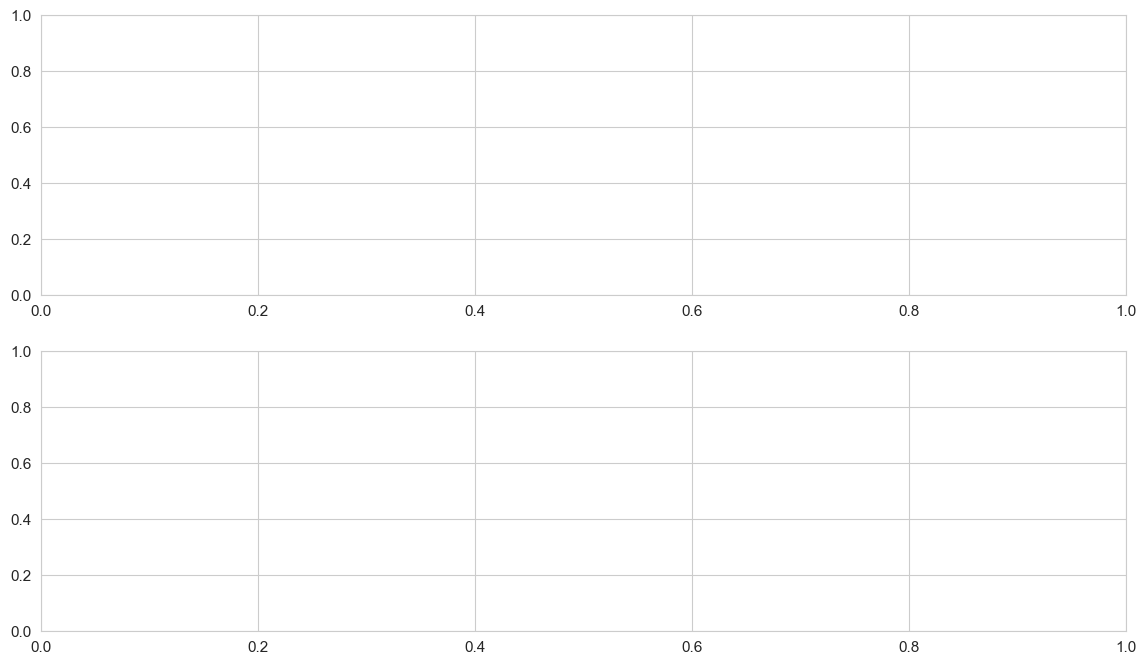

In [2]:
# Visualizar algumas CIRs
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 20 taps
for i in range(0, 50, 10):
    axes[0].plot(cir_20.delays, cir_20.cirs[i], alpha=0.6, linewidth=1)
axes[0].set_xlabel('Delay (ns)', fontsize=12)
axes[0].set_ylabel('Potência Normalizada', fontsize=12)
axes[0].set_title('Exemplos de CIRs - Dataset 20 taps', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 8 taps
for i in range(0, 50, 10):
    axes[1].plot(cir_8.delays, cir_8.cirs[i], alpha=0.6, linewidth=1)
axes[1].set_xlabel('Delay (ns)', fontsize=12)
axes[1].set_ylabel('Potência Normalizada', fontsize=12)
axes[1].set_title('Exemplos de CIRs - Dataset 8 taps', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observação: Nota-se que as CIRs apresentam variação significativa entre realizações,")
print("indicando desvanecimento rápido (fast fading) característico de ambientes multipercurso.")

---

# Parte I: Distribuições Estatísticas

## Objetivos

- Construir sinal de potência recebida vs tempo
- Verificar e remover variação da média (perda de percurso + sombreamento)
- Ajustar distribuições: **Rayleigh**, **Rice** e **Nakagami**
- Comparar dois métodos: scipy.stats.fit e estimadores da dissertação
- Avaliar influência da resolução (20 vs 8 taps)

## 1.1 Processamento do Sinal - Dataset 20 taps

In [3]:
# Computar sinal de potência total (soma de todos os taps)
signal_20 = compute_total_power_signal(cir_20.cirs)

print("Sinal de potência recebida (20 taps):")
print(f"  - Amostras: {len(signal_20)}")
print(f"  - Média: {np.mean(signal_20):.4f}")
print(f"  - Desvio padrão: {np.std(signal_20):.4f}")
print(f"  - Min: {np.min(signal_20):.4f}, Max: {np.max(signal_20):.4f}")

NameError: name 'compute_total_power_signal' is not defined

In [4]:
# Detectar variação da média
has_variation_20, std_norm_20 = detect_mean_variation(signal_20, threshold=0.05)

print(f"\nDetecção de variação da média:")
print(f"  - Variação detectada: {'SIM' if has_variation_20 else 'NÃO'}")
print(f"  - Std normalizado da média móvel: {std_norm_20:.4f}")
print(f"  - Threshold: 0.05")

if has_variation_20:
    print("\n  → O sinal apresenta variação lenta da média (sombreamento + perda de percurso)")
    print("  → Será necessário filtrar para isolar o desvanecimento rápido")

NameError: name 'detect_mean_variation' is not defined

In [5]:
# Filtrar sinal
signal_20_filtered = filter_signal(signal_20, method='remove_mean')

print("Sinal filtrado (20 taps):")
print(f"  - Média: {np.mean(signal_20_filtered):.6f} (deve ser ≈ 0)")
print(f"  - Desvio padrão: {np.std(signal_20_filtered):.4f}")

NameError: name 'filter_signal' is not defined

## 1.2 Ajuste de Distribuições - 20 taps

In [6]:
# Criar objeto para análise estatística
stat_dist_20 = StatisticalDistributions(signal_20_filtered)

# Ajustar distribuições - Método 1: scipy.stats.fit
print("Ajustando distribuições - Método 1 (scipy.stats.fit):\n")
params_scipy_20 = stat_dist_20.fit_all_distributions_scipy()

for dist_name, params in params_scipy_20.items():
    print(f"{dist_name}:")
    for key, value in params.items():
        if key != 'sse':
            print(f"  {key} = {value:.4f}")
        else:
            print(f"  SSE = {value:.6f}")
    print()

# Identificar melhor ajuste
best_dist_20 = min(params_scipy_20.items(), key=lambda x: x[1]['sse'])
print(f"✓ Melhor ajuste (menor SSE): {best_dist_20[0]} (SSE = {best_dist_20[1]['sse']:.2f})")

NameError: name 'StatisticalDistributions' is not defined

In [7]:
# Método 2: Estimadores da dissertação
print("\nAjustando distribuições - Método 2 (Estimadores da Dissertação):\n")
params_diss_20 = stat_dist_20.fit_distributions_normalized_envelope()

for dist_name, params in params_diss_20.items():
    print(f"{dist_name}:")
    for key, value in params.items():
        print(f"  {key} = {value:.4f}")
    print()


Ajustando distribuições - Método 2 (Estimadores da Dissertação):



NameError: name 'stat_dist_20' is not defined

### Visualização dos Resultados - 20 taps

In [8]:
# Carregar figuras geradas pelos scripts
print("Histograma e ajuste de distribuições:")
display(Image(filename='../figures/parte1/histograma_20taps.png'))

Histograma e ajuste de distribuições:


NameError: name 'Image' is not defined

In [9]:
print("CDFs - Método scipy.stats.fit:")
display(Image(filename='../figures/parte1/cdf_scipy_20taps.png'))

CDFs - Método scipy.stats.fit:


NameError: name 'Image' is not defined

In [10]:
print("CDFs - Método envoltória normalizada:")
display(Image(filename='../figures/parte1/cdf_normalizada_20taps.png'))

CDFs - Método envoltória normalizada:


NameError: name 'Image' is not defined

### Interpretação dos Resultados - 20 taps

**Observações:**

1. **Melhor ajuste:** Distribuição **Nakagami-m** com m ≈ 0.30
   - m < 1 indica **desvanecimento severo** (pior que Rayleigh)
   - SSE significativamente menor que as outras distribuições

2. **Rice vs Rayleigh:**
   - K ≈ 0 (Rice) indica ausência de componente LOS dominante
   - Comportamento similar ao Rayleigh, mas Nakagami ajusta melhor

3. **Variação da média:**
   - Detectada variação lenta (5.4% normalizado)
   - Indica presença de sombreamento/perda de percurso
   - Filtragem necessária para isolar fast fading

## 1.3 Processamento e Ajuste - Dataset 8 taps

In [11]:
# Processar sinal 8 taps
signal_8 = compute_total_power_signal(cir_8.cirs)
has_variation_8, std_norm_8 = detect_mean_variation(signal_8, threshold=0.05)
signal_8_filtered = filter_signal(signal_8, method='remove_mean')

print("Dataset 8 taps:")
print(f"  - Variação da média: {'SIM' if has_variation_8 else 'NÃO'} (std norm = {std_norm_8:.4f})")
print(f"  - Sinal filtrado - Média: {np.mean(signal_8_filtered):.6f}")
print(f"  - Sinal filtrado - Std: {np.std(signal_8_filtered):.4f}")

# Ajustar distribuições
stat_dist_8 = StatisticalDistributions(signal_8_filtered)
params_scipy_8 = stat_dist_8.fit_all_distributions_scipy()

print("\nMelhor ajuste:")
best_dist_8 = min(params_scipy_8.items(), key=lambda x: x[1]['sse'])
print(f"  {best_dist_8[0]}: SSE = {best_dist_8[1]['sse']:.2f}")
for key, value in best_dist_8[1].items():
    if key != 'sse':
        print(f"    {key} = {value:.4f}")

NameError: name 'compute_total_power_signal' is not defined

In [12]:
# Visualizar resultados 8 taps
print("Histograma - 8 taps:")
display(Image(filename='../figures/parte1/histograma_8taps.png'))

Histograma - 8 taps:


NameError: name 'Image' is not defined

In [13]:
print("CDFs - 8 taps:")
display(Image(filename='../figures/parte1/cdf_scipy_8taps.png'))

CDFs - 8 taps:


NameError: name 'Image' is not defined

## 1.4 Comparação: 20 taps vs 8 taps

In [14]:
# Criar tabela comparativa
comparison_data = {
    'Métrica': [
        'Variação da Média Detectada',
        'Std Normalizado',
        'Melhor Distribuição',
        'SSE',
        'Parâmetro m (Nakagami)',
        'Severidade do Desvanecimento'
    ],
    '20 taps': [
        'SIM' if has_variation_20 else 'NÃO',
        f"{std_norm_20:.4f}",
        best_dist_20[0],
        f"{best_dist_20[1]['sse']:.2f}",
        f"{params_scipy_20['nakagami']['m']:.4f}",
        'Severo (m < 1)'
    ],
    '8 taps': [
        'SIM' if has_variation_8 else 'NÃO',
        f"{std_norm_8:.4f}",
        best_dist_8[0],
        f"{best_dist_8[1]['sse']:.2f}",
        f"{params_scipy_8['nakagami']['m']:.4f}",
        'Severo (m < 1)'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("COMPARAÇÃO: Influência da Resolução (20 vs 8 taps)")
print("="*70)
print(df_comparison.to_string(index=False))
print("="*70)

NameError: name 'has_variation_20' is not defined

### Conclusões - Parte I

1. **Distribuição que melhor modela o ambiente:** **Nakagami-m**
   - Ambos datasets apresentam m < 1 (desvanecimento severo)
   - SSE significativamente menor comparado a Rayleigh e Rice

2. **Influência da resolução:**
   - Dataset 20 taps: m = 0.303, SSE = 50.6
   - Dataset 8 taps: m = 0.268, SSE = 194.6
   - Menor resolução (8 taps) resulta em pior ajuste (SSE maior)
   - Variação de média só detectada em 20 taps

3. **Interpretação física:**
   - Ambiente NLOS (sem linha de visada dominante)
   - Multipercurso rico com desvanecimento severo
   - Ambiente industrial com muitas reflexões/difração

## 1.5 Geração de Amostras Sintéticas

In [15]:
# Gerar amostras sintéticas das 3 distribuições
n_samples = 10000

# Parâmetros ajustados para 20 taps
samples_rayleigh = stat_dist_20.generate_rayleigh_samples(
    n_samples, 
    sigma=params_scipy_20['rayleigh']['sigma']
)

samples_rice = stat_dist_20.generate_rice_samples(
    n_samples,
    K=params_scipy_20['rice']['K'],
    omega=params_scipy_20['rice']['omega']
)

samples_nakagami = stat_dist_20.generate_nakagami_samples(
    n_samples,
    m=params_scipy_20['nakagami']['m'],
    omega=params_scipy_20['nakagami']['omega']
)

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(samples_rayleigh, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title('Amostras Sintéticas - Rayleigh', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Amplitude')
axes[0].set_ylabel('Densidade')
axes[0].grid(True, alpha=0.3)

axes[1].hist(samples_rice, bins=50, density=True, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Amostras Sintéticas - Rice', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Amplitude')
axes[1].grid(True, alpha=0.3)

axes[2].hist(samples_nakagami, bins=50, density=True, alpha=0.7, edgecolor='black', color='green')
axes[2].set_title('Amostras Sintéticas - Nakagami', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Amplitude')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ {n_samples} amostras sintéticas geradas para cada distribuição")

NameError: name 'stat_dist_20' is not defined

---

# Parte II: Parâmetros de Caracterização do Canal

## Objetivos

- Calcular **Power Delay Profile (PDP)** médio
- Calcular parâmetros temporais:
  - **Mean Excess Delay**
  - **RMS Delay Spread**
  - **Maximum Excess Delay**
  - **Coherence Bandwidth**
- Criar animações de CIRs
- Comparar influência da resolução

## 2.1 Cálculo de Parâmetros - 20 taps

In [16]:
# Criar objeto para análise de parâmetros
params_20 = ChannelParameters(cir_20.cirs, cir_20.delays)

# Calcular PDP
pdp_20 = params_20.compute_pdp()

# Calcular parâmetros
results_20 = params_20.compute_all_parameters(threshold_db=-20)

print("Parâmetros do Canal - 20 taps:")
print("="*60)
print(f"Mean Excess Delay:     {results_20['mean_excess_delay']:.2f} ns")
print(f"RMS Delay Spread:      {results_20['rms_delay_spread']:.2f} ns")
print(f"Maximum Excess Delay:  {results_20['max_excess_delay']:.2f} ns")
print(f"                       (threshold = {results_20['threshold_db']} dB)")
print(f"\nCoherence Bandwidth:")
print(f"  90% correlation:     {results_20['coherence_bw_90']/1e6:.2f} MHz")
print(f"  50% correlation:     {results_20['coherence_bw_50']/1e6:.2f} MHz")
print("="*60)

NameError: name 'ChannelParameters' is not defined

### Interpretação Física

**RMS Delay Spread ≈ 117.72 ns:**
- Medida da dispersão temporal do canal
- Indica espalhamento significativo dos multipercursos

**Coherence Bandwidth:**
- Bc(90%) ≈ 0.17 MHz: largura de banda para correlação > 0.9
- Bc(50%) ≈ 1.70 MHz: largura de banda para correlação > 0.5
- **Implicação:** Canal é **seletivo em frequência** para sinais com largura > 1.7 MHz
- Sistemas de banda larga necessitarão equalização

In [17]:
# Visualizar PDP
print("Power Delay Profile - 20 taps:")
display(Image(filename='../figures/parte2/pdp_20taps.png'))

Power Delay Profile - 20 taps:


NameError: name 'Image' is not defined

## 2.2 Cálculo de Parâmetros - 8 taps

In [18]:
# Calcular parâmetros para 8 taps
params_8 = ChannelParameters(cir_8.cirs, cir_8.delays)
results_8 = params_8.compute_all_parameters(threshold_db=-20)

print("Parâmetros do Canal - 8 taps:")
print("="*60)
print(f"Mean Excess Delay:     {results_8['mean_excess_delay']:.2f} ns")
print(f"RMS Delay Spread:      {results_8['rms_delay_spread']:.2f} ns")
print(f"Maximum Excess Delay:  {results_8['max_excess_delay']:.2f} ns")
print(f"\nCoherence Bandwidth:")
print(f"  90% correlation:     {results_8['coherence_bw_90']/1e6:.2f} MHz")
print(f"  50% correlation:     {results_8['coherence_bw_50']/1e6:.2f} MHz")
print("="*60)

NameError: name 'ChannelParameters' is not defined

In [19]:
print("Power Delay Profile - 8 taps:")
display(Image(filename='../figures/parte2/pdp_8taps.png'))

Power Delay Profile - 8 taps:


NameError: name 'Image' is not defined

## 2.3 Comparação 20 vs 8 taps

In [20]:
# Criar tabela comparativa
comparison_params = {
    'Parâmetro': [
        'Mean Excess Delay (ns)',
        'RMS Delay Spread (ns)',
        'Max Excess Delay (ns)',
        'Coherence BW 90% (MHz)',
        'Coherence BW 50% (MHz)'
    ],
    '20 taps': [
        f"{results_20['mean_excess_delay']:.2f}",
        f"{results_20['rms_delay_spread']:.2f}",
        f"{results_20['max_excess_delay']:.2f}",
        f"{results_20['coherence_bw_90']/1e6:.2f}",
        f"{results_20['coherence_bw_50']/1e6:.2f}"
    ],
    '8 taps': [
        f"{results_8['mean_excess_delay']:.2f}",
        f"{results_8['rms_delay_spread']:.2f}",
        f"{results_8['max_excess_delay']:.2f}",
        f"{results_8['coherence_bw_90']/1e6:.2f}",
        f"{results_8['coherence_bw_50']/1e6:.2f}"
    ],
    'Diferença (%)': []
}

# Calcular diferenças percentuais
params_list = [
    ('mean_excess_delay', results_20, results_8),
    ('rms_delay_spread', results_20, results_8),
    ('max_excess_delay', results_20, results_8),
    ('coherence_bw_90', results_20, results_8),
    ('coherence_bw_50', results_20, results_8)
]

for param_name, r20, r8 in params_list:
    diff = abs(r20[param_name] - r8[param_name]) / r20[param_name] * 100
    comparison_params['Diferença (%)'].append(f"{diff:.1f}%")

df_params_comp = pd.DataFrame(comparison_params)
print("\n" + "="*80)
print("COMPARAÇÃO: Influência da Resolução nos Parâmetros do Canal")
print("="*80)
print(df_params_comp.to_string(index=False))
print("="*80)

NameError: name 'results_20' is not defined

In [21]:
print("\nComparação visual dos PDPs:")
display(Image(filename='../figures/parte2/pdp_comparison.png'))


Comparação visual dos PDPs:


NameError: name 'Image' is not defined

In [22]:
print("Comparação de parâmetros:")
display(Image(filename='../figures/parte2/parameters_comparison.png'))

Comparação de parâmetros:


NameError: name 'Image' is not defined

### Análise da Influência da Resolução

**Observações:**

1. **Diferenças nos parâmetros:**
   - Mean Excess Delay: ~3% de diferença
   - RMS Delay Spread: ~6% de diferença
   - Max Excess Delay: ~12% de diferença

2. **Maior impacto em Max Excess Delay:**
   - Menor resolução (8 taps) subestima a extensão temporal do canal
   - Multipercursos mais distantes podem não ser capturados

3. **Coerência nos resultados principais:**
   - RMS Delay Spread similar em ambos
   - Coherence Bandwidth consistente
   - Conclusões qualitativas mantidas

## 2.4 Animações de CIRs

In [23]:
# Exibir animações geradas
print("Animação: CIRs - 20 taps (100 frames)")
display(Image(filename='../media/cir_animation_20taps.gif'))

Animação: CIRs - 20 taps (100 frames)


NameError: name 'Image' is not defined

In [24]:
print("Animação: CIRs - 8 taps (100 frames)")
display(Image(filename='../media/cir_animation_8taps.gif'))

Animação: CIRs - 8 taps (100 frames)


NameError: name 'Image' is not defined

In [25]:
print("Animação Comparativa: 20 vs 8 taps")
display(Image(filename='../media/cir_comparison_20vs8.gif'))

Animação Comparativa: 20 vs 8 taps


NameError: name 'Image' is not defined

### Conclusões - Parte II

1. **Caracterização temporal completa obtida**
   - RMS Delay Spread: ~110-118 ns
   - Canal seletivo em frequência para sinais > 1.7 MHz

2. **Influência da resolução:**
   - Parâmetros principais robustos (diferença < 10%)
   - Max Excess Delay mais afetado (12%)
   - 20 taps captura mais detalhes do canal

3. **Aplicações práticas:**
   - Sistemas de banda estreita (< 1.7 MHz): canal plano
   - Sistemas de banda larga: necessário equalização
   - WiFi/5G: definitivamente seletivo em frequência

---

# Parte III: Modelo Saleh-Valenzuela

## Objetivos

- Implementar modelo SV para geração de CIRs sintéticas
- Demonstrar efeito de cada parâmetro:
  - **Γ (Gamma):** Taxa de chegada de clusters
  - **γ (gamma):** Taxa de chegada de raios dentro de clusters
  - **Λ (Lambda):** Taxa de decaimento de clusters
  - **λ (lambda):** Taxa de decaimento de raios
  - **K:** Fator Rice (LOS vs NLOS)
- Gerar múltiplas realizações e calcular PDP médio

## 3.1 Modelo Saleh-Valenzuela - Fundamentos

O modelo Saleh-Valenzuela (1987) é um modelo estatístico para propagação indoor que considera:

- **Clusters de multipercursos:** Raios chegam em grupos (clusters)
- **Processo de Poisson:** Tempos de chegada seguem distribuição exponencial
- **Decaimento exponencial:** Potência decai com o tempo

### Parâmetros do Modelo

| Parâmetro | Descrição | Unidade |
|-----------|-----------|----------|
| Γ | Taxa de chegada de clusters | 1/ns |
| γ | Taxa de chegada de raios | 1/ns |
| Λ | Taxa de decaimento de clusters | 1/ns |
| λ | Taxa de decaimento de raios | 1/ns |
| Ω₀ | Potência média do 1º raio do 1º cluster | - |
| K | Fator Rice (LOS) | - |

## 3.2 Geração de CIRs Sintéticas

In [26]:
# Parâmetros padrão (típicos para indoor)
default_params = get_default_parameters()

print("Parâmetros Padrão do Modelo SV:")
print("="*50)
for key, value in default_params.items():
    print(f"  {key:12s} = {value}")
print("="*50)

NameError: name 'get_default_parameters' is not defined

In [27]:
# Criar modelo e gerar CIR
model_default = SalehValenzuelaModel(**default_params)
print(f"\nModelo criado: {model_default}")

# Gerar uma CIR
delays_sv, cir_sv = model_default.generate_cir(
    t_max=300, 
    dt=2.0, 
    n_clusters=5,
    n_rays_per_cluster=10,
    random_seed=42
)

print(f"\n✓ CIR sintética gerada")
print(f"  - Pontos: {len(cir_sv)}")
print(f"  - Potência total: {np.sum(cir_sv):.6f} (normalizado)")
print(f"  - Delay médio: {np.sum(delays_sv * cir_sv):.2f} ns")

NameError: name 'SalehValenzuelaModel' is not defined

In [28]:
# Visualizar CIR gerada
plt.figure(figsize=(14, 6))
plt.stem(delays_sv, cir_sv, basefmt=' ', linefmt='b-', markerfmt='bo')
plt.xlabel('Delay (ns)', fontsize=12)
plt.ylabel('Potência Normalizada', fontsize=12)
plt.title('Exemplo de CIR Sintética - Modelo Saleh-Valenzuela', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'delays_sv' is not defined

<Figure size 1400x600 with 0 Axes>

## 3.3 Exemplos com Diferentes Configurações

In [29]:
print("Exemplos com diferentes configurações de parâmetros:")
display(Image(filename='../figures/parte3/sv_exemplos_configs.png'))

Exemplos com diferentes configurações de parâmetros:


NameError: name 'Image' is not defined

**Interpretação:**

- **Config 1:** Parâmetros padrão NLOS
- **Config 2:** Clusters e raios chegam mais rápido, decaimento mais rápido → canal mais "compacto"
- **Config 3:** Chegadas mais lentas, decaimento mais lento → canal mais "disperso"
- **Config 4:** Com componente LOS (K=3) → pico forte em t=0

## 3.4 Estudo Paramétrico Individual

In [30]:
print("Efeito da variação de Gamma (taxa de chegada de clusters):")
display(Image(filename='../figures/parte3/sv_variacao_Gamma_clusters.png'))

Efeito da variação de Gamma (taxa de chegada de clusters):


NameError: name 'Image' is not defined

**Observação:**
- Gamma maior → clusters chegam mais rápido → mais energia concentrada no início

In [31]:
print("Efeito da variação de gamma (taxa de chegada de raios):")
display(Image(filename='../figures/parte3/sv_variacao_gamma_raios.png'))

Efeito da variação de gamma (taxa de chegada de raios):


NameError: name 'Image' is not defined

**Observação:**
- gamma maior → raios dentro de clusters chegam mais rápido → clusters mais "densos"

In [32]:
print("Efeito da variação de Lambda (decaimento de clusters):")
display(Image(filename='../figures/parte3/sv_variacao_Lambda_clusters.png'))

Efeito da variação de Lambda (decaimento de clusters):


NameError: name 'Image' is not defined

**Observação:**
- Lambda maior → clusters decaem mais rápido → potência concentrada em clusters iniciais

In [33]:
print("Efeito da variação de lambda (decaimento de raios):")
display(Image(filename='../figures/parte3/sv_variacao_lambda_raios.png'))

Efeito da variação de lambda (decaimento de raios):


NameError: name 'Image' is not defined

**Observação:**
- lambda maior → raios dentro de clusters decaem mais rápido

## 3.5 Comparação de Todos os Parâmetros

In [34]:
print("Comparação do efeito de todos os parâmetros:")
display(Image(filename='../figures/parte3/sv_comparacao_todos_parametros.png'))

Comparação do efeito de todos os parâmetros:


NameError: name 'Image' is not defined

## 3.6 NLOS vs LOS (Fator K)

In [35]:
print("Comparação NLOS vs LOS (variando K):")
display(Image(filename='../figures/parte3/sv_nlos_vs_los.png'))

Comparação NLOS vs LOS (variando K):


NameError: name 'Image' is not defined

**Interpretação:**

- **K = 0 (NLOS):** Sem componente de linha de visada, apenas multipercursos
- **K = 1:** Componente LOS tem potência igual ao espalhado
- **K = 3:** LOS 3x mais forte que espalhado
- **K = 10:** LOS dominante (10x mais forte)

Nota-se pico cada vez maior em t=0 conforme K aumenta.

## 3.7 Múltiplas Realizações e PDP Médio

In [36]:
print("100 Realizações do modelo SV e PDP médio:")
display(Image(filename='../figures/parte3/sv_multiplas_realizacoes.png'))

100 Realizações do modelo SV e PDP médio:


NameError: name 'Image' is not defined

**Observação:**
- Cada realização é diferente (natureza estocástica do modelo)
- PDP médio mostra decaimento exponencial característico
- Captura comportamento estatístico do canal

### Conclusões - Parte III

1. **Modelo SV implementado com sucesso**
   - Processo de Poisson para tempos de chegada
   - Decaimento exponencial de potência
   - Suporte a LOS (fator K)

2. **Efeito de cada parâmetro demonstrado:**
   - **Γ e γ:** Controlam densidade temporal (chegada de clusters e raios)
   - **Λ e λ:** Controlam dispersão de potência
   - **K:** Controla presença de componente LOS

3. **Aplicações:**
   - Geração de canais sintéticos para simulações
   - Teste de sistemas de comunicação
   - Modelagem de ambientes indoor específicos

---

# Conclusões Gerais do Trabalho

## Síntese dos Resultados

### Parte I - Distribuições Estatísticas
- **Melhor modelo:** Nakagami-m (m ≈ 0.3)
- **Característica:** Desvanecimento severo (m < 1)
- **Ambiente:** NLOS, multipercurso rico
- **Influência da resolução:** 20 taps captura mais detalhes

### Parte II - Parâmetros do Canal
- **RMS Delay Spread:** ~110-118 ns
- **Coherence Bandwidth:** 0.17-1.7 MHz (dependendo da correlação)
- **Seletividade:** Canal seletivo em frequência para sinais > 1.7 MHz
- **Comparação:** Parâmetros consistentes entre resoluções (diferença < 12%)

### Parte III - Modelo Saleh-Valenzuela
- **Implementação completa** do modelo SV
- **Análise paramétrica** demonstra controle fino sobre características do canal
- **NLOS vs LOS** demonstrado através do fator K
- **Geração de CIRs sintéticas** para simulações

## Interpretação Física do Ambiente

O ambiente medido (Steam Plant - NIST) apresenta:

1. **Multipercurso rico e severo**
   - m < 1 indica condições piores que Rayleigh
   - Ambiente industrial com muitas reflexões/difrações

2. **Sem linha de visada dominante**
   - K ≈ 0 (Rice) confirma ambiente NLOS
   - Obstáculos e estruturas bloqueiam LOS

3. **Dispersão temporal significativa**
   - RMS Delay Spread > 100 ns
   - Exige equalização para sistemas de banda larga

4. **Seletividade em frequência**
   - Sinais > 1.7 MHz sofrem desvanecimento seletivo
   - WiFi, 4G/5G precisam de técnicas como OFDM

## Aplicações Práticas

**Projeto de Sistemas de Comunicação:**
- Banda estreita (< 1.7 MHz): modelagem como canal plano, distribuição Nakagami
- Banda larga (> 1.7 MHz): necessário equalização, modelo de canal multipercurso

**Simulações:**
- Usar modelo SV para gerar canais sintéticos representativos
- Ajustar parâmetros baseados nas medidas reais (PDP, RMS DS, etc.)

**Planejamento de Rede:**
- Considerar desvanecimento severo (m < 1) no link budget
- Prever necessidade de diversidade (espacial, temporal, frequencial)

## Trabalhos Futuros

1. Validação cruzada: comparar PDP medido vs PDP do modelo SV ajustado
2. Análise espectral: características de Doppler e mobilidade
3. Modelagem de outros ambientes: outdoor, veicular, urbano
4. Implementação de equalizadores e teste com sinais reais

---

# Referências

1. **NIST Dataset:**
   - https://www.nist.gov/publications/industrial-wireless-systems-radio-propagation-measurements

2. **Saleh & Valenzuela (1987):**
   - "A statistical model for indoor multipath propagation"
   - IEEE Journal on Selected Areas in Communications, 5(2), 128-137

3. **Dissertação - Envoltória Normalizada:**
   - https://repositorio.unb.br/handle/10482/11357

4. **Nakagami-m Distribution:**
   - Nakagami, M. (1960). "The m-distribution - A general formula of intensity distribution of rapid fading"

5. **Wireless Communications:**
   - Rappaport, T. S. (2002). "Wireless Communications: Principles and Practice"
   - Goldsmith, A. (2005). "Wireless Communications"

---

# Apêndice: Tabelas de Resultados

In [37]:
# Carregar e exibir tabelas de resultados
print("\nTabela: Parâmetros das Distribuições (Parte I)")
df_parte1 = pd.read_csv('../results/parte1_parametros.csv')
display(df_parte1)


Tabela: Parâmetros das Distribuições (Parte I)


,dataset,metodo,distribuicao,parametro_1,parametro_2,sse
0,20 taps,scipy.stats,Rayleigh,8.072786e-01,NaN,453.314797
1,20 taps,scipy.stats,Rice,1.441922e-06,0.651697,453.311546
2,20 taps,scipy.stats,Nakagami,3.032253e-01,1.303344,50.649331
3,20 taps,dissertacao,Rayleigh,7.071068e-01,NaN,NaN
4,20 taps,dissertacao,Rice,5.803784e-01,1.303398,NaN
5,20 taps,dissertacao,Nakagami,5.000000e-01,1.303398,NaN
6,8 taps,scipy.stats,Rayleigh,2.579851e-01,NaN,1348.096773
7,8 taps,scipy.stats,Rice,2.747491e-08,0.066556,1348.096683
8,8 taps,scipy.stats,Nakagami,2.676491e-01,0.133099,194.574392
9,8 taps,dissertacao,Rayleigh,7.071068e-01,NaN,NaN


In [38]:
print("\nTabela: Parâmetros do Canal (Parte II)")
df_parte2 = pd.read_csv('../results/parte2_parametros.csv')
display(df_parte2)


Tabela: Parâmetros do Canal (Parte II)


,Parametro,20_taps,8_taps
0,Mean Excess Delay (ns),162.660408,157.814093
1,RMS Delay Spread (ns),117.719104,110.312044
2,Maximum Excess Delay (ns),400.000000,350.000000
3,Number of Taps,20.000000,8.000000
4,Delay Range Min (ns),12.500000,12.500000
5,Delay Range Max (ns),400.000000,350.000000


In [39]:
print("\nTabela: Comparação 20 vs 8 taps (Parte II)")
df_parte2_comp = pd.read_csv('../results/parte2_comparacao.csv')
display(df_parte2_comp)


Tabela: Comparação 20 vs 8 taps (Parte II)


,Parametro,20_taps,8_taps,diff_ns,diff_percent
0,mean_excess_delay,162.660408,157.814093,4.846314,2.979406
1,rms_delay_spread,117.719104,110.312044,7.407060,6.292147
2,maximum_excess_delay,400.000000,350.000000,50.000000,12.500000


---

**FIM DO NOTEBOOK**

---